<a href="https://colab.research.google.com/github/Ridhima00/invoice-bounding-box-app/blob/master/RealTimeObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow tensorflow-hub tensorflow-datasets opencv-python matplotlib


In [23]:
from google.colab import files
uploaded = files.upload()


Saving WIN_20240827_19_18_44_Pro.jpg to WIN_20240827_19_18_44_Pro.jpg


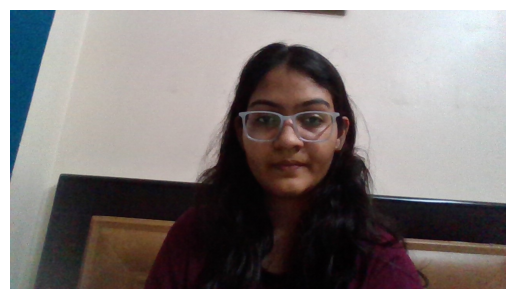

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return np.asarray(image_rgb)

def show_image(image_np):
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

# Load and display the uploaded image
image_path = list(uploaded.keys())[0]  # Get the uploaded file name
image_np = load_image(image_path)
show_image(image_np)


In [27]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the pre-trained model from TensorFlow Hub
model_handle = 'https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1'
model = hub.load(model_handle).signatures['default']


In [28]:
def detect_objects(image_np):
    # Normalize the image to be between 0 and 1
    image_np = image_np.astype(np.float32) / 255.0

    image_tensor = tf.convert_to_tensor(image_np)
    image_tensor = image_tensor[tf.newaxis, ...]

    result = model(image_tensor)

    # Print the keys of the result dictionary to inspect its contents
    print(result.keys())

    # Extract detection results (adjust keys if necessary based on the printed output)
    boxes = result['detection_boxes'][0].numpy()
    # Check if 'detection_classes' exists, if not, try 'detection_class_entities'
    class_ids = result.get('detection_classes', result.get('detection_class_entities'))[0].numpy()
    scores = result['detection_scores'][0].numpy()

    return boxes, class_ids, scores

# Run object detection
boxes, class_ids, scores = detect_objects(image_np)


dict_keys(['detection_boxes', 'detection_scores', 'detection_class_names', 'detection_class_entities', 'detection_class_labels'])


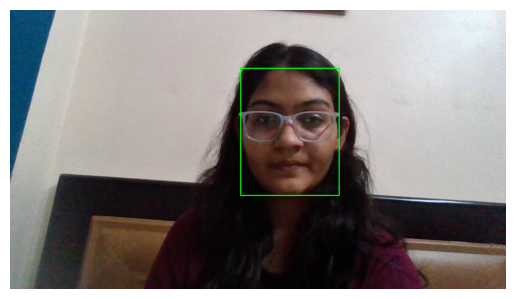

In [29]:
def draw_boxes(image_np, boxes, class_ids, scores):
    image_copy = image_np.copy()
    # Handle the case where scores is a single value
    if not isinstance(scores, (list, np.ndarray)):
        scores = [scores]  # Convert to a list for iteration
        boxes = [boxes] # Convert to a list for iteration

    # Draw boxes on the image
    for box, class_id, score in zip(boxes, class_ids, scores):
        if score > 0.5:  # Confidence threshold
            # Ensure box is a 1D array before unpacking
            box = np.squeeze(box)  # Remove single-dimensional entries from the shape of an array.
            ymin, xmin, ymax, xmax = box
            (left, right, top, bottom) = (xmin * image_copy.shape[1], xmax * image_copy.shape[1],
                                          ymin * image_copy.shape[0], ymax * image_copy.shape[0])
            cv2.rectangle(image_copy, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)

    return image_copy

# Draw bounding boxes and display the result
image_with_boxes = draw_boxes(image_np, boxes, class_ids, scores)
show_image(image_with_boxes)
